# Carbon Pricing Efficacy
This document contains carbon pricing efficacy code, which was written by Benjamin D. Fedoruk, Kai Fucile Ladouceur, Russell Frost, and Harrison Nelson. 

## Imports
Below are the imports used for the project

In [2]:
!pip install pandas

  Using cached pandas-1.3.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.5 MB)
     |████████████████████████████████| 510 kB 809 kB/s eta 0:00:01
     |████████████████████████████████| 15.8 MB 1.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/benfedoruk/Code/ipynb/jupyterenv/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install matplotlib

You should consider upgrading via the '/home/benfedoruk/Code/ipynb/jupyterenv/bin/python -m pip install --upgrade pip' command.


In [34]:
!pip install statsmodels

  Using cached statsmodels-0.12.2-cp39-cp39-manylinux1_x86_64.whl (9.4 MB)
  Using cached patsy-0.5.1-py2.py3-none-any.whl (231 kB)
  Using cached scipy-1.7.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
You should consider upgrading via the '/home/benfedoruk/Code/ipynb/jupyterenv/bin/python -m pip install --upgrade pip' command.


In [1]:
!pip install ipynb

  Using cached ipynb-0.5.1-py3-none-any.whl (6.9 kB)
You should consider upgrading via the '/home/benfedoruk/Code/ipynb/jupyterenv/bin/python -m pip install --upgrade pip' command.


In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import copy

## Constants

In [120]:
MIN_YEAR = 2003
MAX_YEAR = 2019
X_COL = 'year'
Y_COLS = ['volume', 'co2_norm']
Y_INDEX_TO_PLOT = 0
SELECTED_ISO_CODE = 'FRA'

## Useful Functions

In [151]:
def normalize(df, col):
    amax, amin = max(df[col]), min(df[col])
    results = []
    for val in df[col].tolist():
        results.append((val - amin) / (amax - amin))
    return results

def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
def grangers_causation_matrix(data, variables, test='ssr_ftest', maxlag = 10, verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    df_index = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables,dtype='int')
    total_p_vals = []
    for c in df.columns:
        row = []
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            row.append({f"{c},{r}":p_values})
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
            df_index.loc[r, c] = np.argmin(p_values)+1
        total_p_vals.append(row)
        
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    df_index.columns = [var + '_x' for var in variables]
    df_index.index = [var + '_y' for var in variables]
    return df, df_index, total_p_vals

def plot_grangers_causation(p_vals, maxlag = 10):   
    x = range(1,maxlag+1)
    dimension = len(p_vals[0])
    figure, axes = plt.subplots(dimension, dimension, figsize=(20, 20))
    figure.tight_layout(pad=3.0)
    for row in axes:
        i = np.where(axes == row)[0][0]
        for column in row:
            j = np.where(row == column)[0][0]
            plot_title,y = list(p_vals[i][j].items())[0]
            column.plot(x,y, c='blue')
            column.plot(x,len(x)*[0.05], c='red')
            y_label,t = plot_title.split(',')
            column.title.set_text(t)
            column.grid()
            if j%8 == 0:
                column.set_ylabel(y_label)
    plotSnapFileName = './granger-pics/granger_causation_' + now + '.pdf'
    figToSave=plt.gcf()
    figToSave.savefig(plotSnapFileName,dpi=600, bbox_inches="tight")
    plt.show()

## Import the CSV Datasets

In [82]:
emissions = pd.read_csv('data/emissions.csv')
headlines = pd.read_csv('data/headlines.csv')

In [83]:
search_term = "CARBON"
countries = ['ALB', 'AUT', 'BLR', 'BEL', 'BIH', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'GRL', 'HUN', 'ISL', 'IRL', 'ITA', 'LVA', 'LIE', 'LTU', 'LUX', 'MLT', 'MDA', 'MNE', 'NLD', 'MKD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SRB', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'TUR', 'UKR', 'GBR']

In [84]:
headlines['headline_text'] = headlines['headline_text'].apply(lambda x : x.upper())
headlines = headlines[headlines['headline_text'].str.contains(search_term)]

## Granularity

In [85]:
headline_years = []
for _, row in headlines.iterrows():
    headline_years.append(int(str(row.publish_date)[:4]))
headlines['year'] = headline_years

In [86]:
headlines = headlines[['year', 'headline_text']]

In [87]:
headlines

,year,headline_text
25256,2003,FUNDS FOR TREATING CARBON DIOXIDE EMISSIONS
33456,2003,WA SHIRE CREATES CARBON SINK
45164,2003,STATE FORESTS BACKS CARBON TRADING SCHEME
70192,2004,HUBBLE FINDS OXYGEN CARBON AROUND DISTANT PLANET
77858,2004,RAINFORESTS ABSORBING LESS CARBON DIOXIDE STUDY
...,...,...
1220849,2020,AUSTRALIAN FARMERS URGED TO IMPROVE CARBON NEU...
1221111,2020,A GLOBAL CARBON PRICE COULD SOON BE A REALITY ...
1222964,2020,BLUE CARBON A GAMECHANGER IN WA GREENHOUSE GAS...
1223662,2020,CAN QLD ACHIEVE NET ZERO CARBON EMISSIONS BY 2...


In [88]:
headlines.to_pickle('data/headlines_clean.pkl')

In [89]:
volume = []
years = []
for _, row in headlines.iterrows():
    if not row.year in years:
        years.append(row.year)
        volume.append(1)
    else:
        volume[-1] += 1
print(list(zip(volume, years)))

[(3, 2003), (6, 2004), (7, 2005), (40, 2006), (114, 2007), (142, 2008), (128, 2009), (95, 2010), (653, 2011), (376, 2012), (217, 2013), (172, 2014), (76, 2015), (58, 2016), (30, 2017), (21, 2018), (35, 2019), (40, 2020)]


In [90]:
volumes = pd.DataFrame(list(zip(volume, years)), columns=['volume', 'year'])
volumes.to_pickle('data/volumes.pkl')

Attempting ALB (1 of 43).
Attempting AUT (2 of 43).
Attempting BLR (3 of 43).
Attempting BEL (4 of 43).
Attempting BIH (5 of 43).
Attempting BGR (6 of 43).
Attempting HRV (7 of 43).
Attempting CYP (8 of 43).
Attempting CZE (9 of 43).
Attempting DNK (10 of 43).
Attempting EST (11 of 43).
Attempting FIN (12 of 43).
Attempting FRA (13 of 43).
Attempting DEU (14 of 43).
Attempting GRC (15 of 43).
Attempting GRL (16 of 43).
Attempting HUN (17 of 43).
Attempting ISL (18 of 43).
Attempting IRL (19 of 43).
Attempting ITA (20 of 43).
Attempting LVA (21 of 43).
Attempting LIE (22 of 43).
Attempting LTU (23 of 43).
Attempting LUX (24 of 43).
Attempting MLT (25 of 43).
Attempting MDA (26 of 43).
Attempting MNE (27 of 43).
Attempting NLD (28 of 43).
Attempting MKD (29 of 43).
Attempting NOR (30 of 43).
Attempting POL (31 of 43).
Attempting PRT (32 of 43).
Attempting ROU (33 of 43).
Attempting RUS (34 of 43).
Attempting SRB (35 of 43).
Attempting SVK (36 of 43).
Attempting SVN (37 of 43).
Attempting

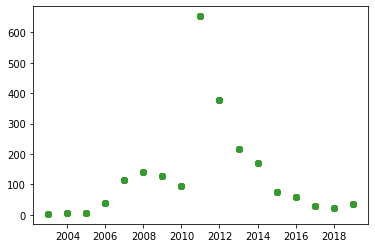

In [100]:
count = 0
list_of_dfs = []

for i, country in enumerate(countries):
    count += 1
    print(f'Attempting {country} ({count} of {len(countries)}).')
    emissions = pd.read_csv('data/emissions.csv')
    emissions = emissions[['year', 'iso_code', 'country', 'co2', 'co2_per_capita', 'cumulative_co2', 'co2_per_gdp']]
    emissions = emissions[emissions['year'] >= MIN_YEAR]
    emissions = emissions[emissions['iso_code'] == country]
    
    if emissions['co2'].tolist() == []:
        continue
    amin, amax = min(emissions['co2']), max(emissions['co2'])
    if amin == amax:
        continue
        
    
    emissions['co2_norm'] = normalize(emissions, 'co2')
    
    volumes_list = []
    for _, row in emissions.iterrows():
        volumes_list.append(volume[row.year - MIN_YEAR])
    emissions['volume'] = volumes_list
    
    relevant_cols = copy.deepcopy(Y_COLS)
    relevant_cols.append(X_COL)
    relevant_cols.append('iso_code')
    list_of_dfs.append(emissions[relevant_cols].loc[:,~emissions[relevant_cols].columns.duplicated()])
    
    plt.scatter(emissions[X_COL], emissions[Y_COLS[Y_INDEX_TO_PLOT]])

## Heteroscedasticity

In [101]:
concat_country_df = pd.concat(list_of_dfs)
fit = smf.ols(f'{X_COL} ~ {Y_COLS[Y_INDEX_TO_PLOT]}', data=concat_country_df).fit()
print(fit.summary())
heteroscedasticity_names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
breusch_pagan_results = sms.het_breuschpagan(fit.resid, fit.model.exog)
print(lzip(heteroscedasticity_names, breusch_pagan_results))

                            OLS Regression Results                            
Dep. Variable:                   year   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.982
Date:                Wed, 01 Sep 2021   Prob (F-statistic):             0.0464
Time:                        00:51:38   Log-Likelihood:                -2196.8
No. Observations:                 731   AIC:                             4398.
Df Residuals:                     729   BIC:                             4407.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2010.7127      0.231   8695.052      0.0

## Stationarity

In [124]:
list_of_tuples_log = []
for y_col in Y_COLS:
    for country_df in list_of_dfs:
        diff_df = country_df[y_col].diff().dropna()
        length = len(diff_df.tolist())
        country = country_df['iso_code'].tolist()[0]
        list_of_tuples_log.append((country_df[y_col].diff().dropna(), country, y_col))
print(list_of_tuples_log)

[(278      3.0
279      1.0
280     33.0
281     74.0
282     28.0
283    -14.0
284    -33.0
285    558.0
286   -277.0
287   -159.0
288    -45.0
289    -96.0
290    -18.0
291    -28.0
292     -9.0
293     14.0
Name: volume, dtype: float64, 'ALB', 'volume'), (1734      3.0
1735      1.0
1736     33.0
1737     74.0
1738     28.0
1739    -14.0
1740    -33.0
1741    558.0
1742   -277.0
1743   -159.0
1744    -45.0
1745    -96.0
1746    -18.0
1747    -28.0
1748     -9.0
1749     14.0
Name: volume, dtype: float64, 'AUT', 'volume'), (2437      3.0
2438      1.0
2439     33.0
2440     74.0
2441     28.0
2442    -14.0
2443    -33.0
2444    558.0
2445   -277.0
2446   -159.0
2447    -45.0
2448    -96.0
2449    -18.0
2450    -28.0
2451     -9.0
2452     14.0
Name: volume, dtype: float64, 'BLR', 'volume'), (2628      3.0
2629      1.0
2630     33.0
2631     74.0
2632     28.0
2633    -14.0
2634    -33.0
2635    558.0
2636   -277.0
2637   -159.0
2638    -45.0
2639    -96.0
2640    -18.0
2641    -28.0

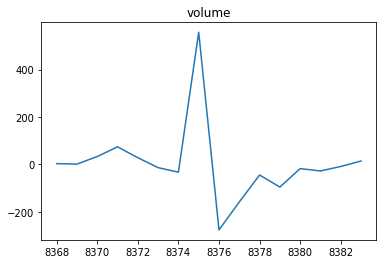

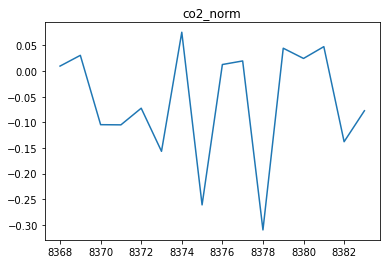

In [126]:
for tpl in list_of_tuples_log:
    if tpl[1] == SELECTED_ISO_CODE:
        tpl[0].plot()
        plt.title(tpl[2])
        plt.show()

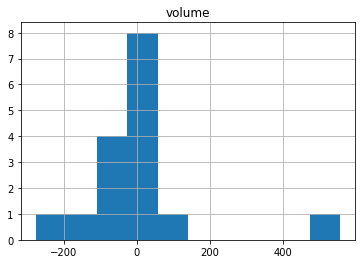

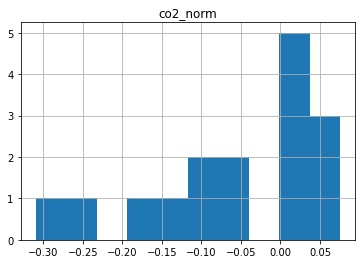

In [127]:
for tpl in list_of_tuples_log:
    if tpl[1] == SELECTED_ISO_CODE:
        tpl[0].hist()
        plt.title(tpl[2])
        plt.show()

In [134]:
for tpl in list_of_tuples_log:
    if tpl[1] == SELECTED_ISO_CODE:
        print(f'ADF Statistics for {tpl[2]}')
        augmented_dickey_fuller_statistics(tpl[0])

ADF Statistics for volume
ADF Statistic: -4.675801
p-value: 0.000093
Critical Values:
	1%: -3.964
	5%: -3.085
	10%: -2.682
ADF Statistics for co2_norm
ADF Statistic: -5.595270
p-value: 0.000001
Critical Values:
	1%: -3.964
	5%: -3.085
	10%: -2.682


In [149]:
dfs_critical_list = []
for tpl in list_of_tuples_log:
    if tpl[1] == SELECTED_ISO_CODE:
        dfs_critical_list.append(tpl[0])

combined_names = []

combined_dict = {df.name: df for df in dfs_critical_list}
combined_dict['year'] = range(MIN_YEAR, MAX_YEAR)
combined_df = pd.DataFrame({df.name: df for df in dfs_critical_list})

In [154]:
results, min_index, p_vals = grangers_causation_matrix(combined_df, variables=list(combined_df.columns))

ValueError: Insufficient observations. Maximum allowable lag is 4